# Figure. Pluripotency Markers eQTLs

In [1]:
import cPickle
import glob
import os
import random
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pybedtools as pbt
from scipy.stats import fisher_exact
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as sms
import tabix
import vcf as pyvcf
import weblogolib as logo

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_pluripotency_markers_eqtls'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

fn = '/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_processing/no_peer_no_std_norm01/h2.tsv'
h2 = pd.read_table(fn, index_col=0, header=None, squeeze=True)

fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
resid_exp = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
exp = pd.read_table(fn, index_col=0)

In [3]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
rna_meta = rna_meta[rna_meta.in_eqtl]

In [4]:
fn = os.path.join(ciepy.root, 'private_output', 'eqtl_input', 
                  'filtered_all', '0000.vcf.gz')
vcf_reader = pyvcf.Reader(open(fn), compressed=True)
res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'eqtls01', 
                                 'gene_results', '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])

qvalue_sig = qvalues[qvalues.perm_sig == 1]
qvalue_sig = qvalue_sig.sort_values('perm_qvalue')

In [5]:
log_exp = np.log10(exp + 1)
#log_exp = (log_exp.T - log_exp.mean(axis=1)).T
log_exp = log_exp[rna_meta.index]
log_exp.columns = rna_meta.wgs_id

In [6]:
# Markers of pluripotency from http://www.nature.com/nbt/journal/v33/n11/full/nbt.3387.html.
pgenes = ['CXCL5', 'IDO1', 'LCK', 'TRIM22', 'DNMT3B', 'HESX1', 'SOX2', 'POU5F1', 'NANOG']
genes = []
for g in pgenes:
    i = gene_info[gene_info.gene_name == g].index[0]
    if i in qvalues[qvalues.perm_sig].index:
        genes.append(i)

In [7]:
pdf = gene_info.ix[genes]
t_h2 = []
t_r2 = []
for g in pdf.index:
    fn = os.path.join(ciepy.root, 'private_output/run_eqtl_analysis/no_peer_no_std_norm01/gene_results', 
                      g, '{}.tsv'.format(g))
    res = ciepy.read_emmax_output(fn)
    res = res.sort_values('PVALUE')
    t_r2.append(res.R2.values[0])
    fn = os.path.join(ciepy.root, 'private_output/run_eqtl_analysis/no_peer_no_std_norm01/gene_results', 
                      g, '{}.reml'.format(g))
    t_h2.append(pd.read_table(fn, index_col=0, header=None, squeeze=True)['h2'])
pdf['r2'] = t_r2
pdf['h2'] = t_h2
pdf

,gene_name,gene_type,chrom,start,end,strand,gene_status,source,level,r2,h2
gene_id,,,,,,,,,,,
ENSG00000163735.6,CXCL5,protein_coding,chr4,74861358,74864496,-,KNOWN,HAVANA,2,0.18400,0.799549
ENSG00000131203.8,IDO1,protein_coding,chr8,39759793,39785963,+,KNOWN,HAVANA,2,0.10650,0.715645
ENSG00000182866.12,LCK,protein_coding,chr1,32716839,32751766,+,KNOWN,HAVANA,2,0.05772,0.666568
ENSG00000204531.11,POU5F1,protein_coding,chr6,31132118,31148508,-,KNOWN,HAVANA,1,0.19070,0.799549


In [8]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered.tsv')
t = pd.read_table(fn, index_col=0)

In [9]:
def eqtl_violin(gene_id, exp, ax):
    res = ciepy.read_emmax_output(res_fns[gene_id])
    res = res.sort_values('PVALUE')
    t =  vcf_reader.fetch(res.CHROM.values[0], 
                          res.BEG.values[0], 
                          res.BEG.values[0] + 1)
    r = t.next()
    tdf = pd.DataFrame(exp.ix[gene_id])
    tdf.columns = ['Expression']
    tdf['Genotype'] = 0
    hets = set(exp.columns) & set([s.sample for s in r.get_hets()])
    tdf.ix[hets, 'Genotype'] = 1
    alts = set(exp.columns) & set([s.sample for s in r.get_hom_alts()])
    tdf.ix[alts, 'Genotype'] = 2
    ax = sns.violinplot(x='Genotype', y='Expression', data=tdf, color='grey',
                        order=[0, 1, 2], scale='count', linewidth=0.5)
    ax.set_ylabel('$\\log_{10}$ TPM', fontsize=8)
    for t in ax.get_xticklabels() + ax.get_yticklabels():
        t.set_fontsize(8)
    sns.regplot(x='Genotype', y='Expression', data=tdf, scatter=False, color='red', 
                ci=None, line_kws={'linewidth':0.8})
    ax.set_ylabel('$\\log_{10}$ TPM', fontsize=8)
    ya, yb = plt.ylim()
    ax.set_xlabel('')
    ax.set_xticklabels(['Homo.\nref.', 'Het.', 'Homo.\nalt.'], fontsize=8)
    return tdf

In [10]:
sns.set_style('whitegrid')

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/matplotlib/gridspec.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


AttributeError: 'list' object has no attribute 'hist'

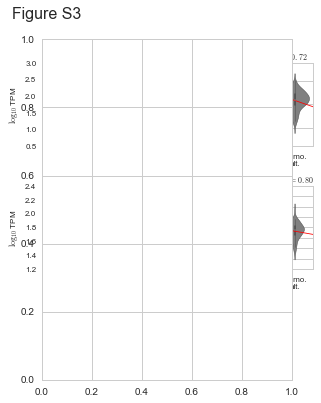

In [11]:
fig = plt.figure(figsize=(4.48, 6.1), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 1, 'Figure S3',
        size=16, va='top')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.9, 0.5, 1])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
i = 0
t = eqtl_violin(pdf.index[i], log_exp, ax)
textstr = '{}; $R^2={:.2f}$; $h^2={:.2f}$'.format(
    gene_info.ix[pdf.index[i], 'gene_name'], pdf.ix[i, 'r2'], pdf.ix[i, 'h2'])
ax.set_title(textstr, fontsize=8)
gs.tight_layout(fig, rect=[0, 0.58, 0.5, 0.9])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
i = 1
t = eqtl_violin(pdf.index[i], log_exp, ax)
textstr = '{}; $R^2={:.2f}$; $h^2={:.2f}$'.format(
    gene_info.ix[pdf.index[i], 'gene_name'], pdf.ix[i, 'r2'], pdf.ix[i, 'h2'])
ax.set_title(textstr, fontsize=8)
gs.tight_layout(fig, rect=[0.5, 0.58, 1, 0.9])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
i = 2
t = eqtl_violin(pdf.index[i], log_exp, ax)
textstr = '{}; $R^2={:.2f}$; $h^2={:.2f}$'.format(
    gene_info.ix[pdf.index[i], 'gene_name'], pdf.ix[i, 'r2'], pdf.ix[i, 'h2'])
ax.set_title(textstr, fontsize=8)
gs.tight_layout(fig, rect=[0, 0.3, 0.5, 0.62])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
i = 3
t = eqtl_violin(pdf.index[i], log_exp, ax)
ax.set_title(gene_info.ix[pdf.index[i], 'gene_name'], fontsize=8)
textstr = '{}; $R^2={:.2f}$; $h^2={:.2f}$'.format(
    gene_info.ix[pdf.index[i], 'gene_name'], pdf.ix[i, 'r2'], pdf.ix[i, 'h2'])
ax.set_title(textstr, fontsize=8)
gs.tight_layout(fig, rect=[0.5, 0.3, 1, 0.62])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
h2.hist(bins=np.arange(0, 1.01, 0.01), ax=ax)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_ylabel('Numbe of genes', fontsize=8)
ax.set_xlabel('$h^2$ estimated by EMMAX', fontsize=8)
gs.tight_layout(fig, rect=[0, 0, 1, 0.33])

t = fig.text(0.005, 0.865, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.865, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.585, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.585, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.31, 'E', weight='bold', 
             size=12)

In [12]:
h2.hist()

AttributeError: 'list' object has no attribute 'hist'